In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_excel("online_retail_II.xlsx")

In [4]:
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64


In [6]:
df = df[df['CustomerID'].notnull()]

KeyError: 'CustomerID'

In [7]:
print(df.columns)

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


In [8]:
df = df[df['Customer ID'].notnull()]

In [10]:
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

In [11]:
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

In [12]:
df = df.drop_duplicates()

In [13]:
print("\nShape of cleaned data:", df.shape)
df.head()


Shape of cleaned data: (400916, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [14]:
df.columns = df.columns.str.strip()

In [16]:
df.rename(columns={'Customer ID': 'CustomerID', 'Price': 'UnitPrice'}, inplace=True)

In [17]:
print(df.columns)

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


In [18]:
import datetime

In [19]:
latest_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [20]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                   # Frequency
    'UnitPrice': lambda x: round((x * df.loc[x.index, 'Quantity']).sum(), 2)  # Monetary
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.reset_index(inplace=True)


In [22]:
print("RFM table preview:")
rfm.head()


RFM table preview:


,CustomerID,Recency,Frequency,Monetary
0,12346.0,165,11,372.86
1,12347.0,3,2,1323.32
2,12348.0,74,1,222.16
3,12349.0,43,3,2671.14
4,12351.0,11,1,300.93


In [23]:
from sklearn.preprocessing import StandardScaler

rfm_data = rfm[['Recency', 'Frequency', 'Monetary']]

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)

print("First 5 scaled values:")
print(rfm_scaled[:5])


First 5 scaled values:
[[ 0.76229851  0.80108727 -0.18713934]
 [-0.91040156 -0.3006029  -0.08047459]
 [-0.17730462 -0.42301292 -0.20405155]
 [-0.4973892  -0.17819288  0.07078363]
 [-0.82779909 -0.42301292 -0.19521163]]


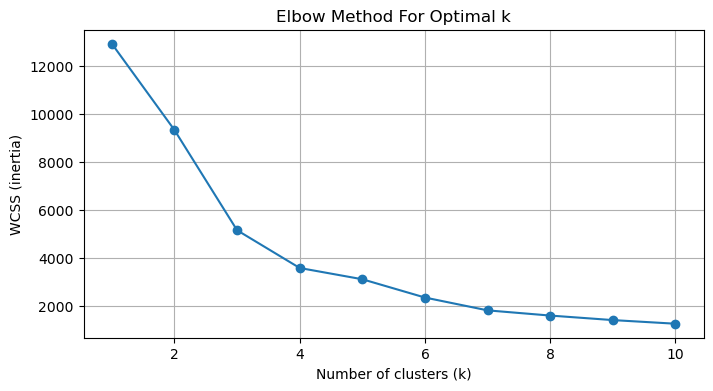

In [24]:
from sklearn.cluster import KMeans
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (inertia)')
plt.grid(True)
plt.show()


In [25]:

kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(rfm_scaled)

rfm['Cluster'] = kmeans.labels_

rfm.head()


,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,165,11,372.86,1
1,12347.0,3,2,1323.32,0
2,12348.0,74,1,222.16,0
3,12349.0,43,3,2671.14,0
4,12351.0,11,1,300.93,0


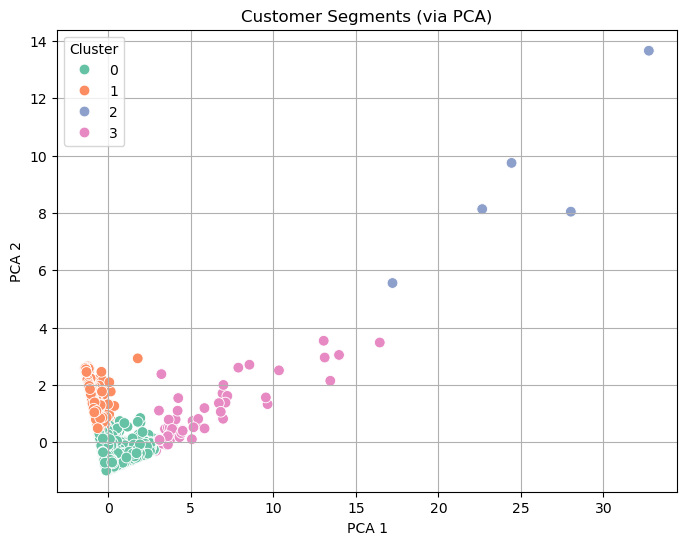

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)


rfm['PCA1'] = rfm_pca[:, 0]
rfm['PCA2'] = rfm_pca[:, 1]


plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=60)
plt.title('Customer Segments (via PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()


In [27]:

cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Num_Customers'})

cluster_summary = cluster_summary.round(2)
cluster_summary


,Recency,Frequency,Monetary,Num_Customers
Cluster,,,,
0,43.03,4.46,1710.65,3204
1,242.98,1.66,593.54,1047
2,5.60,113.60,215535.00,5
3,14.91,47.02,28896.42,56


In [28]:

cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Num_Customers'})

cluster_summary = cluster_summary.round(2)
cluster_summary


,Recency,Frequency,Monetary,Num_Customers
Cluster,,,,
0,43.03,4.46,1710.65,3204
1,242.98,1.66,593.54,1047
2,5.60,113.60,215535.00,5
3,14.91,47.02,28896.42,56
